In [36]:
import pandas as pd
import numpy as np
import os
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

plt.style.use("seaborn-v0_8")

In [11]:
os.getcwd()

'/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/src/perception/perception/scripts'

In [12]:
csv_path = '/media/rl16432/Shared/Documents/Engineering/SOFTENG700/autonomous_f1tenth/perception_debug/24_09_10_17:41:35/bev/ego_poses.csv'

df = pd.read_csv(csv_path)

# normalise the time from df to start at 0
df['time_norm'] = df['time'] - df['time'].min()
df

,time,qx,qy,qz,qw,tx,ty,tz,time_norm
0,1.725947e+09,-0.358581,0.860522,0.147591,-0.330360,-1.844481,0.068709,2.866100,0.000000
1,1.725947e+09,-0.358489,0.861626,0.150218,-0.326376,-1.846532,0.068712,2.869110,0.005459
2,1.725947e+09,-0.358056,0.861568,0.150398,-0.326921,-1.844259,0.068577,2.865942,0.010880
3,1.725947e+09,-0.360432,0.860121,0.152592,-0.327103,-1.839103,0.068488,2.857654,0.023501
4,1.725947e+09,-0.358307,0.861538,0.146630,-0.328433,-1.848658,0.068816,2.872581,0.040540
...,...,...,...,...,...,...,...,...,...
296,1.725947e+09,-0.358515,0.860732,0.147897,-0.329747,-1.845928,0.068864,2.868263,4.974689
297,1.725947e+09,-0.358941,0.860363,0.149523,-0.329515,-1.842463,0.068541,2.863015,4.991465
298,1.725947e+09,-0.359207,0.860492,0.148085,-0.329538,-1.844231,0.068750,2.865428,5.007867
299,1.725947e+09,-0.358134,0.860962,0.146854,-0.330028,-1.846173,0.068659,2.868271,5.024671


In [13]:
# get numerical values of outliers
q1 = df['tx'].quantile(0.25)

z_tx: pd.Series = stats.zscore(df['tx'])
z_tx = z_tx.apply(lambda x: abs(x))

z_ty: pd.Series = stats.zscore(df['ty'])
z_ty = z_ty.apply(lambda x: abs(x))

z_tz: pd.Series = stats.zscore(df['tz'])
z_tz = z_tz.apply(lambda x: abs(x))

# get all the unique indexes of the outliers

outliers = pd.concat((z_tx[z_tx > 3], z_ty[z_ty > 3], z_tz[z_tz > 3])).index.unique()
df.iloc[outliers]

,time,qx,qy,qz,qw,tx,ty,tz,time_norm
223,1.725947e+09,-0.28399,0.918987,0.272254,-0.026257,0.392691,0.062006,2.997447,3.640999


In [14]:
df_proc = df.drop(outliers)
df_proc = df_proc.sort_values(by='time_norm', ascending=True)
df_proc.describe()

,time,qx,qy,qz,qw,tx,ty,tz,time_norm
count,3.000000e+02,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,1.725947e+09,-0.358401,0.861161,0.148529,-0.328455,-1.845620,0.068727,2.867809,2.492108
std,1.468561e+00,0.000606,0.000707,0.001787,0.001827,0.002603,0.000139,0.003990,1.468561
min,1.725947e+09,-0.360432,0.859702,0.141691,-0.333533,-1.852026,0.068304,2.857561,0.000000
25%,1.725947e+09,-0.358864,0.860645,0.147340,-0.329694,-1.847277,0.068640,2.865377,1.219635
50%,1.725947e+09,-0.358325,0.861127,0.148552,-0.328455,-1.845649,0.068734,2.867954,2.499430
75%,1.725947e+09,-0.357986,0.861642,0.149645,-0.327138,-1.843944,0.068817,2.870411,3.762077
max,1.725947e+09,-0.356760,0.863365,0.153277,-0.322400,-1.839076,0.069073,2.877469,5.041476


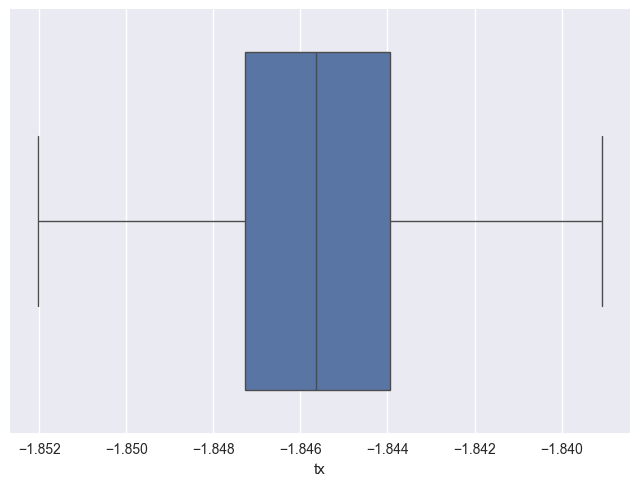

In [15]:
# find outliers in the x and y positions
sns.boxplot(x=df_proc['tx'])
plt.show()

In [16]:
from numpy.polynomial.polynomial import Polynomial

degree = 5
tx_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['tx'], degree)
ty_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['ty'], degree)
tz_model: Polynomial = Polynomial.fit(df_proc['time_norm'], df_proc['tz'], degree)

In [39]:
tx_preds = tx_model(df_proc['time_norm'])
ty_preds = ty_model(df_proc['time_norm'])
tz_preds = tz_model(df_proc['time_norm'])

tx_residuals = df_proc['tx'] - tx_preds
ty_residuals = df_proc['ty'] - ty_preds
tz_residuals = df_proc['tz'] - tz_preds

confidence = 0.95
tx_se = np.sqrt(sum(tx_residuals ** 2) / (len(tx_residuals) - degree - 1))
ty_se = np.sqrt(sum(ty_residuals ** 2) / (len(ty_residuals) - degree - 1))
tz_se = np.sqrt(sum(tz_residuals ** 2) / (len(tz_residuals) - degree - 1))

z_score = stats.norm.ppf(1 - (1 - confidence) / 2)

# (tx_residuals.sum() / (len(tx_residuals) - degree-1))
# tx_se = np.std(tx_residuals)

tx_confidence = z_score * tx_se
ty_confidence = z_score * ty_se
tz_confidence = z_score * tz_se

tx_confidence

0.005095715736910669

<AxesSubplot: xlabel='time_norm'>

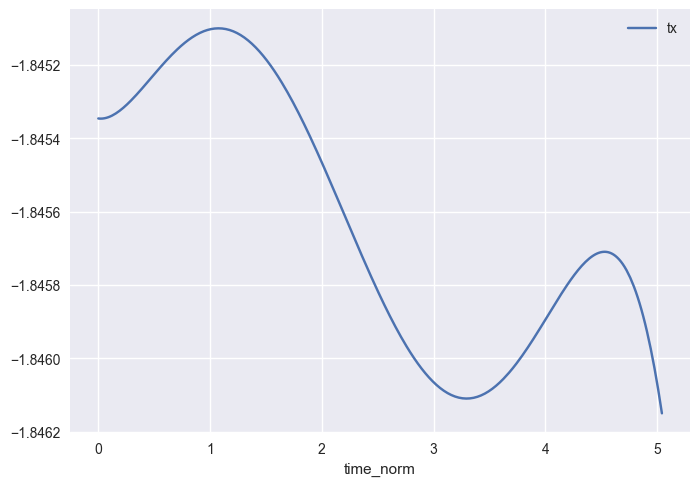

In [17]:
pd.DataFrame((np.vstack((df_proc["time_norm"].values, tx_model(df_proc["time_norm"]))).T), columns=["time_norm", "tx"]).plot(x="time_norm", y="tx")

<AxesSubplot: xlabel='time_norm', ylabel='tz'>

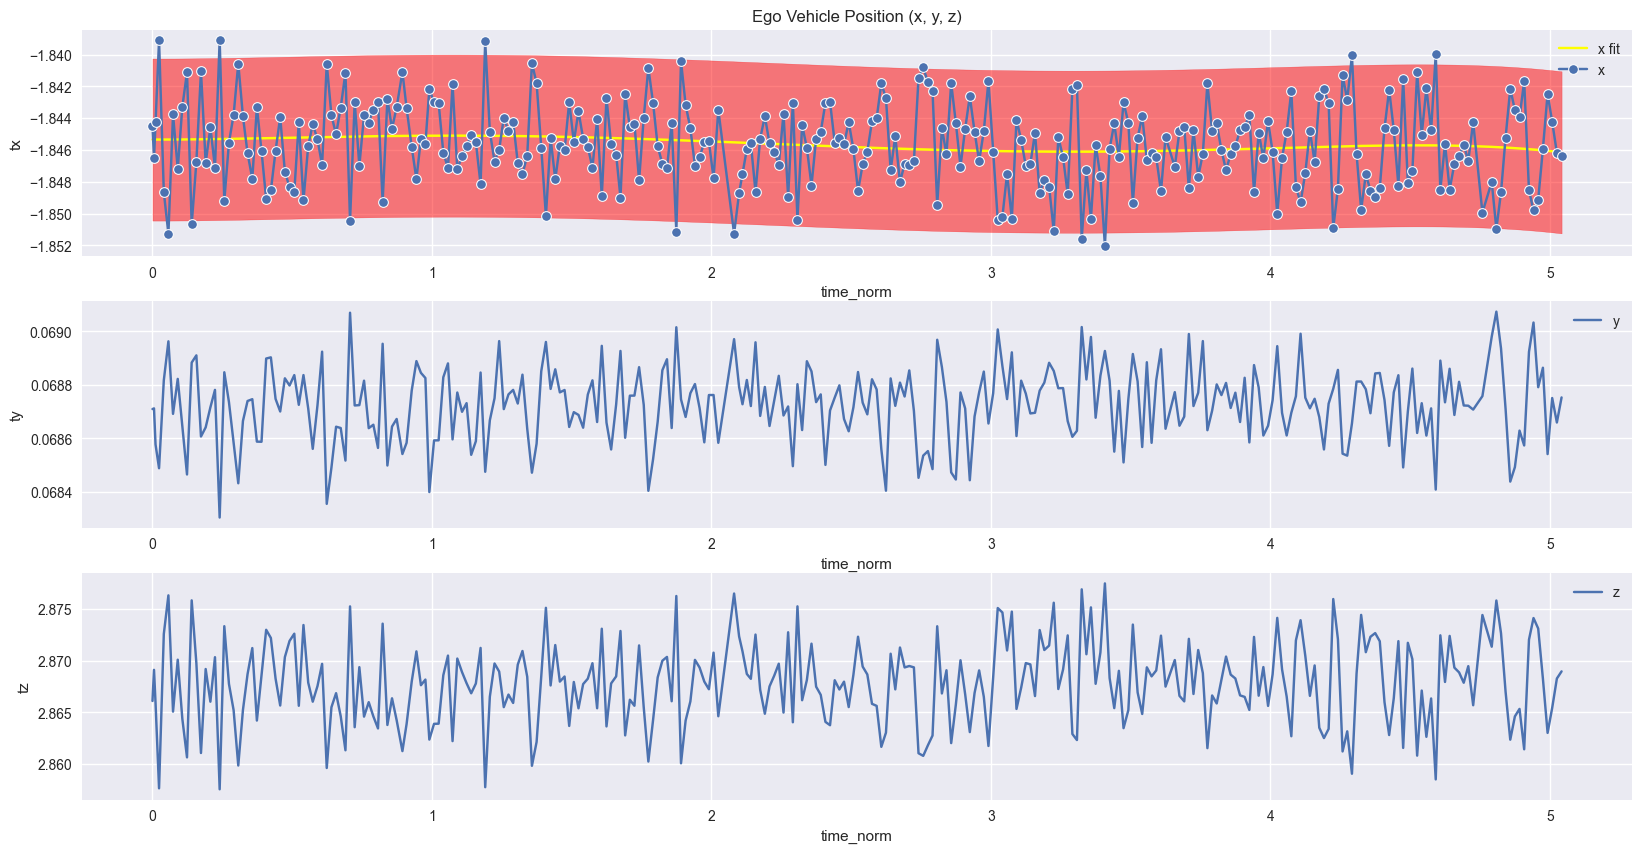

In [43]:
# plot the x and y positions
plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.title('Ego Vehicle Position (x, y, z)')
# plot the polynomial fit
plt.plot(df_proc['time_norm'], np.array(tx_model(df_proc['time_norm'])), label='x fit', markersize='5', color='yellow')
# show the confidence interval
plt.fill_between(df_proc['time_norm'], np.array(tx_model(df_proc['time_norm'])) - tx_confidence, 
                 np.array(tx_model(df_proc['time_norm'])) + tx_confidence, alpha=0.5, color='red')
sns.lineplot(data=df_proc, x='time_norm', y='tx', label='x', marker='o')

plt.subplot(3, 1, 2)
sns.lineplot(data=df_proc, x='time_norm', y='ty', label='y')

plt.subplot(3, 1, 3)
sns.lineplot(data=df_proc, x='time_norm', y='tz', label='z')